###  Doing spectral analysis

The methods to compute the spectral analysis can be imported as follows:

In [1]:
import sys
sys.path.insert(1, '/home/vinicius/GrayData-Analysis')

import time
import numpy                 as     np
import matplotlib.pyplot     as     plt
from   GDa.spectral_analysis import filtering, time_frequency
from   GDa.session           import session

Loading a session using the session class:

In [2]:
ses = session(raw_path = '../GrayLab/', monkey = 'lucy', date = '150128', session = 1,\
              slvr_msmod = False, align_to = 'cue', trial_type = 1, \
              behavioral_response = 1, evt_dt = [-0.65, 3.00])
ses.read_from_mat()

We can plot a random LFP signal:

In [3]:
lfp   = ses.data[0,10,:]
# Time axis, using from -0.65 to 3.00 s because this is the event dt we used when we saved the data
tarr  = ses.time

Text(0, 0.5, 'mV')

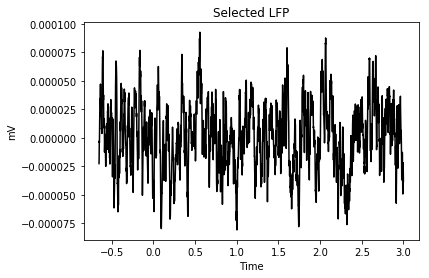

In [4]:
# Plotting the signal
plt.plot(tarr, lfp, 'k')
plt.title('Selected LFP')
plt.xlabel('Time')
plt.ylabel('mV')

We can bandpass filter the data with the function __bp_filter__ from __filtering__, let's filter it on the alpha band (8-15 Hz):

In [5]:
LFP_filtered = filtering.bp_filter(data = ses.data, fs = ses.readinfo['fsample'], 
                                   f_low = 8, f_high = 12, n_jobs = -1)

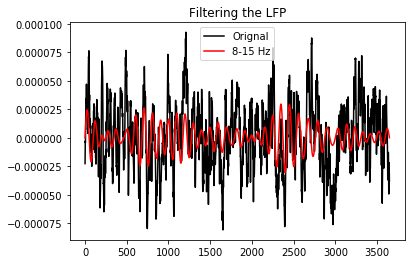

In [6]:
plt.plot(lfp, 'k')
plt.plot(LFP_filtered[0,10,:], 'r')
plt.title('Filtering the LFP')
plt.legend(['Orignal', '8-15 Hz'])

We can compute the wavelets of the signal using the function __wavelet_transform__, which allows to use morlet or multitaper transforms.

In [7]:
# Defining frequencies
delta = [4,5,6,7]
alpha = [8,10,12,14]
beta  = [16,20,24,28,30,34] 
low_gamma  = np.arange(40, 70, 4)  
high_gamma = np.arange(70, 100, 4)
freqs = np.concatenate((delta, alpha, beta, low_gamma, high_gamma))

# Morlet
W_ml = time_frequency.wavelet_transform(data = ses.data,  
                                        fs = ses.readinfo['fsample'], freqs = freqs, n_cycles = freqs/2,
                                        time_bandwidth = None, delta = 15, method = 'morlet', n_jobs = -1)

# Multitaper
#W_mt = spec.wavelet_transform(data = LFP,  
#                              fs = fsample, freqs = freqs, n_cycles = freqs/2.0,
#                              time_bandwidth = 8.0, delta = 15, method = 'multitaper', n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:   16.0s remaining:   23.3s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:   18.0s remaining:   11.4s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:   19.6s remaining:    4.4s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:   21.0s finished


The auto spectra can be computed as tem elementwise product of $W$ and its conjugate:

In [8]:
Sauto_ml = W_ml * np.conj(W_ml)

Next, we can visualize the result for __trial=0__, and __channel=10__:

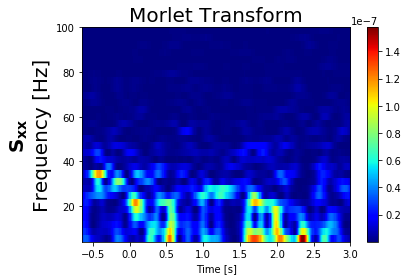

In [9]:
plt.imshow(Sauto_ml[0,10,:,:].real, aspect='auto', cmap='jet', origin='lower', extent=[-0.65,3.00,4,100])
plt.colorbar()
plt.title('Morlet Transform', fontsize=20)
plt.ylabel(r"$\bf{S_{xx}}$" + "\n" + "Frequency [Hz]", fontsize=20)
plt.xlabel('Time [s]')
plt.tight_layout()

Finally we can compute the (single trial) time-frequency coherence between two signals by using the function __wavelet_coherence__, for each trial and pair a file will be saved in __dir_out__ with the coherence data.

An array with the pairs of channels (pairs = $[[0,1], [0,2], \dots, [n,n]]$) should be passed to the function (note that you don't necessarily have to provide every pair possible, you can also focus on a few pairs you are interested).

If $n_{\rm jobs}>1$, it will parallelize on pairs of channels, to test let's compute it passing only one trial of the data, and measure the execution time:

In [10]:
start = time.time()

time_frequency.wavelet_coherence(data = ses.data[:10,:,:], pairs = ses.readinfo['pairs'], fs = ses.readinfo['fsample'], 
                                 freqs = freqs, n_cycles = freqs/2, time_bandwidth = None, delta = 15, method = 'morlet', 
                                 win_time = 34, win_freq = 1, dir_out = 'data', n_jobs = -1)

end = time.time()

print('Elapsed time to load super-tensor: ' +str((end - start)) + ' sec.' )

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:    0.5s finished


Elapsed time to load super-tensor: 12.055751085281372 sec.


We can load a saved file with the coherence in order to plot:

In [11]:
import h5py
with h5py.File('data/ch1_10_ch2_30.h5', 'r') as hf:
    coh = np.array(hf.get('coherence'))

Text(0.5, 0, 'Time [s]')

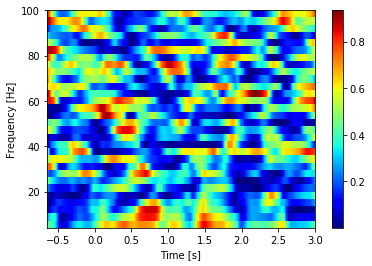

In [12]:
plt.imshow(coh[0,:,:], aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65,3,4,100]); plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')

The spectral analysis class also have the __gabor_coherence__ method which allows computing the coherence between a pair os signals, since it is not built uppon MNE the parameters we should pass are not the whole data but two single LFP signals, let's call this funtion for the same signals we have plot above (__trial=0__, __channel1=10__, and __channel2=30__).

In [13]:
signal1 = ses.data[0,10,:]
signal2 = ses.data[0,30,:]

coh_gabor = time_frequency.gabor_coherence(signal1 = signal1, signal2 = signal2, fs = ses.readinfo['fsample'], 
                                           freqs = freqs, win_time = 500, win_freq = 3, n_cycles = 5)

Text(0.5, 0, 'Time [s]')

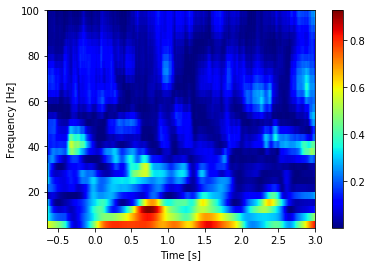

In [14]:
plt.imshow(coh_gabor.real, aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65,3,4,100]); plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')

As it can be seen the results as pretty similar, as expected.

### How parameters influences

In [15]:
win_time = 50
win_freq = [1, 3]
n_cycles = [5, freqs/2.0]
time_bandwidth = [None, 8.0]

#### Morlet

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:    5.9s remaining:    8.5s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:    5.9s remaining:    3.8s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:    6.0s remaining:    1.4s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:    6.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:    5.8s remaining:    8.4s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:    5.9s remaining:    3.7s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:    5.9s remaining:    1.3s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:    6.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:    5.8s remaining:    8.5s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:    5.9

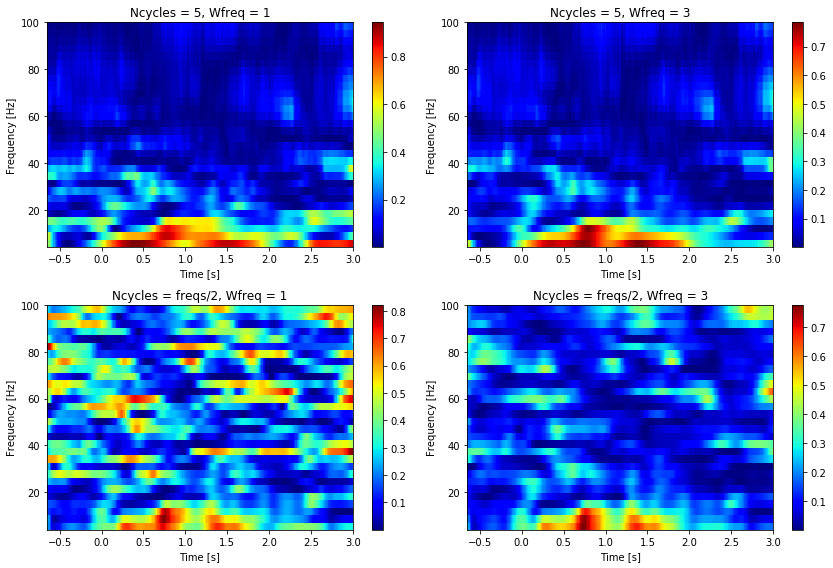

In [16]:
plt.figure(figsize=(12,8))
count = 1
for i in range(len(n_cycles)):
    for j in range(len(win_freq)):
        time_frequency.wavelet_coherence(data = ses.data[:10,:,:], pairs = ses.readinfo['pairs'], 
                                     fs = ses.readinfo['fsample'], freqs = freqs, n_cycles = n_cycles[i], 
                                     time_bandwidth = None, delta = 15, method = 'morlet', 
                                     win_time = win_time, win_freq = win_freq[j], dir_out = 'data', n_jobs = -1)

        with h5py.File('data/ch1_10_ch2_30.h5', 'r') as hf:
            coh = np.array(hf.get('coherence'))
            
        plt.subplot(2, 2, count)
        plt.imshow(coh[0,:,:].real, aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65,3,4,100])
        plt.colorbar()
        if i == 0: plt.title('Ncycles = ' + str(n_cycles[i]) + ', Wfreq = ' + str(win_freq[j]))
        else: plt.title('Ncycles = freqs/2, Wfreq = ' + str(win_freq[j]))
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [s]')
        count += 1
plt.tight_layout()

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:    6.1s remaining:    8.8s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:    6.2s remaining:    3.9s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:    6.3s remaining:    1.4s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:    6.5s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:    7.0s remaining:   10.2s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:    7.2s remaining:    4.5s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:    7.5s remaining:    1.7s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:    7.9s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:    6.1s remaining:    8.9s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:    6.3

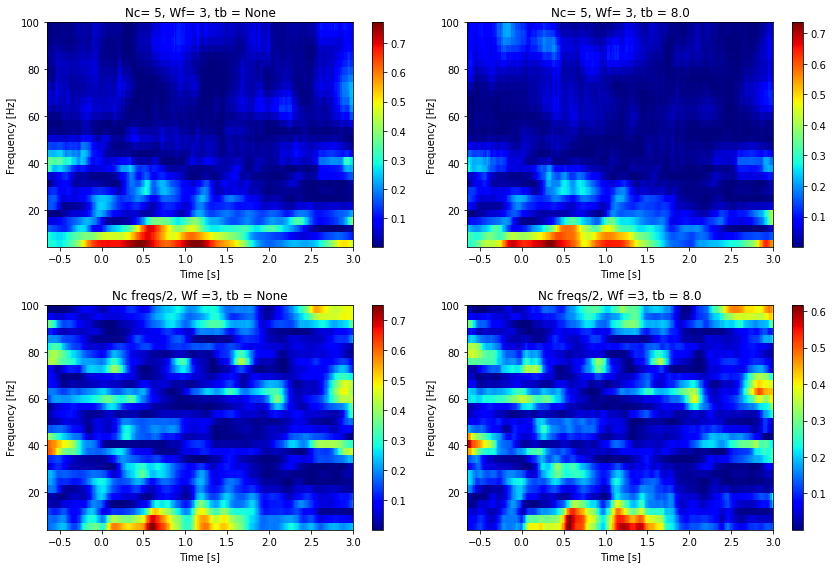

In [17]:
plt.figure(figsize=(12,8))
count = 1
for i in range(len(n_cycles)):
    for k in range(len(time_bandwidth)):
        time_frequency.wavelet_coherence(data = ses.data[:10,:,:], pairs = ses.readinfo['pairs'], 
                                         fs = ses.readinfo['fsample'], freqs = freqs, n_cycles = n_cycles[i], 
                                         time_bandwidth = time_bandwidth[k], delta = 15, method = 'multitaper', 
                                         win_time = win_time, win_freq = 3, dir_out = 'data', n_jobs = -1)

        with h5py.File('data/ch1_10_ch2_30.h5', 'r') as hf:
            coh = np.array(hf.get('coherence'))

        plt.subplot(2,2,count)
        plt.imshow(coh[0,:,:].real, aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65,3,4,100])
        plt.colorbar()
        if i == 0: plt.title('Nc= ' + str(n_cycles[i]) + ', Wf= ' + str(win_freq[1]) + ', tb = ' + str(time_bandwidth[k]))
        else: plt.title('Nc freqs/2, Wf =' + str(win_freq[1])  + ', tb = ' + str(time_bandwidth[k]))
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [s]')
        count += 1
plt.tight_layout()

In [18]:
bands        = np.array([[4,8],[8,15],[15,40],[40,70], [70,100]])
super_tensor = coh[:,:,:].real.mean(axis = 0)
temp         = np.zeros([len(bands), super_tensor.shape[-1]]) 
for i in range( len(bands) ):
    fidx      = (freqs>=bands[i][0])*(freqs<bands[i][1])
    temp[i,:] = super_tensor[fidx,:].mean(axis=0)

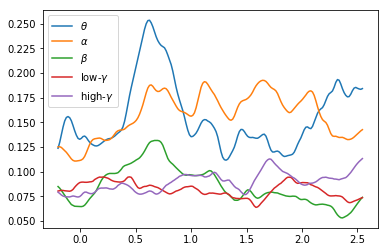

In [19]:
for i in range(len(bands)):
    plt.plot(ses.time[::15][30:-30], temp[i, 30:-30])
plt.legend([r'$\theta$', r'$\alpha$', r'$\beta$', r'low-$\gamma$', r'high-$\gamma$'])

### SUPERLETS

In [87]:
try:
    import cupy as cp
    from cusignal.convolution.convolve import fftconvolve
except:
    cp = np
    from scipy.signal import fftconvolve
    np.asnumpy = np.asarray


def bw_cf(t, bw, cf):
    """Computes the complex wavelet coefficients for the desired time point t,
    bandwidth bw and center frequency cf"""
    cnorm = 1 / (bw * np.sqrt(2 * np.pi))
    exp1 = cnorm * np.exp(-(t ** 2) / (2 * (bw ** 2)));
    res = np.exp(2j * np.pi * cf * t) * exp1
    return res


def gauss(t, sd):
    """Compute the gaussian coefficient for the desired time point t and
    standard deviation sd"""
    cnorm = 1 / (sd * np.sqrt(2 * np.pi))
    res = cnorm * np.exp(-(t ** 2) / (2 * (sd ** 2)))
    return res


def cxmorlet(fc, n_cycles, sfreq):
    """Computes the complex Morlet wavelet for the desired center frequency.
    
    Parameters
    ----------
    fc : center frequency
    n_cycles : number of cycles
    sfreq : sampling frequency
    """
    # we want to have the last peak at 2.5 SD
    sd = (n_cycles / 2) * (1 / fc) / 2.5
    wl = int(2 * np.floor(np.fix(6 * sd * sfreq) / 2) + 1)
    w = np.zeros((wl), dtype=np.complex128)
    gi = 0
    off = np.fix(wl / 2)
    for i in range(wl):
        t = (i - off) / sfreq
        w[i] = bw_cf(t, sd, fc)
        gi += gauss(t, sd)
    w /= gi
    return w


def aslt(data, sfreq, foi, n_cycles, order=None, mult=False):
    """Adaptive superresolution wavelet (superlet) transform.
    
    - data (array_like) : (n_epochs, n_times)
    - sfreq (float) : sampling frequency
    - foi (array_like) : central frequency of interest
    - n_cycles (integer) : number of initial wavelet cycles
    - order (array_like) : interval of super-resolution orders of shape (2,).
      For example, use order=[1, 30]
    - mult (bool) : specifies the use of multiplicative super-resolution (True)
      or additive (False)
    """
    # inputs checking
    assert isinstance(data, np.ndarray)
    data = np.atleast_2d(data).astype(np.float32)
    n_epochs, n_times = data.shape
    foi = np.asarray(foi)
    n_freqs = len(foi)

    # check order parameter and initialize the order used at each frequency. If
    # empty, go with an order of 1 for each frequency (single wavelet per set)
    if order is not None:
        order_ls = np.fix(np.linspace(order[0], order[1], n_freqs)).astype(int)
    else:
        order_ls = np.ones((n_freqs,), dtype=np.int)
        
    # the padding will be size of the lateral zero-pads, which serve to avoid
    # border effects during convolution
    padding = 0
    
    # the wavelet sets
    wavelets = dict()
    
    # initialize wavelet sets for either additive or multiplicative
    # superresolution
    for i_freq in range(n_freqs):
        for i_ord in range(order_ls[i_freq]):
            # get the number of cycles
            if mult:  # multiplicative superresolution
                n_cyc = n_cycles * (i_ord + 1)
            else:     # additive superresolution
                n_cyc = n_cycles + i_ord
            
            # each new wavelet has n_cyc extra cycles
            _w = cxmorlet(foi[i_freq], n_cyc, sfreq)
            
            # the margin will be the half-size of the largest wavelet
            padding = max(padding, np.fix(len(_w) / 2))
            
            wavelets[(i_freq, i_ord)] = _w
    
    # the zero-padded buffer
    buffer = cp.zeros((n_epochs, int(n_times + 2 * padding)),
                      dtype=cp.float32)

    # convenience indexers for the zero-padded buffer
    bufbegin = int(padding)
    bufend = int(padding + n_times)
    
    # fill the central part of the buffer with input data
    buffer[:, bufbegin:bufend] = cp.asarray(data)
    
    # the output scalogram
    wtresult = cp.zeros((n_epochs, n_freqs, n_times), dtype=cp.float32)

    for i_freq in range(n_freqs):
        # pooling buffer, starts with 1 because we're doing geometric mean
        temp = cp.ones((n_epochs, n_times), dtype=cp.float32)

        # compute the convolution of the buffer with each wavelet in the
        # current set
        for i_ord in range(order_ls[i_freq]):
            # get the single wavelets
            sw = cp.asarray(wavelets[(i_freq, i_ord)]).reshape(1, -1)
    
            # restricted convolution (input size == output size)
            _temp = fftconvolve(buffer, sw, mode='same', axes=1)

            # accumulate the magnitude (times 2 to get the full spectral
            # energy
            temp *= (2 * cp.abs(_temp[:, bufbegin:bufend]))

        # compute the power of the geometric mean
        root = 1. / float(order_ls[i_freq])
        temp = (temp ** root) ** 2

        # accumulate the current FOI to the result spectrum
        wtresult[:, i_freq, :] += temp
    
    return cp.asnumpy(wtresult)

In [88]:
delta = [4,5,6,7]
alpha = [8,10,12,14]
beta  = [16,20,24,28,30,34] 
low_gamma  = np.arange(40, 70, 4)  
high_gamma = np.arange(70, 100, 4)
foi = np.concatenate((delta, alpha, beta, low_gamma, high_gamma))

n_cycles = 6
sfreq = 1000.

tf = aslt(ses.data[:,0,:], sfreq, foi, n_cycles, order=[1, 10], mult=True)

In [ ]:
W_aslt = tf.mean(axis = 0)

In [ ]:
aux = tf[:,:,::15].mean(axis=0)
aux = (aux-aux.mean(axis=1)[:,None])/aux.std(axis=1)[:,None]
plt.imshow(aux, aspect='auto', cmap='jet', origin='lower', 
           extent = [ses.time[0],ses.time[-1],foi[0],foi[-1]])
plt.colorbar()

In [82]:
W_ml = time_frequency.wavelet_transform(data = ses.data[:,10,:][:,None,:],  
                                        fs = ses.readinfo['fsample'], freqs = foi, n_cycles = 6,
                                        time_bandwidth = None, delta = 15, method = 'morlet', n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    6.4s finished


In [83]:
W_dwt = np.squeeze( (W_ml * np.conj(W_ml)).real)

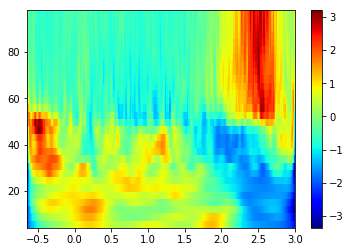

In [84]:
aux = W_dwt.mean(axis=0)
aux = (aux-aux.mean(axis=1)[:,None])/aux.std(axis=1)[:,None]
plt.imshow(aux, aspect='auto', cmap='jet', origin='lower', 
           extent = [ses.time[0],ses.time[-1],foi[0],foi[-1]])
plt.colorbar()

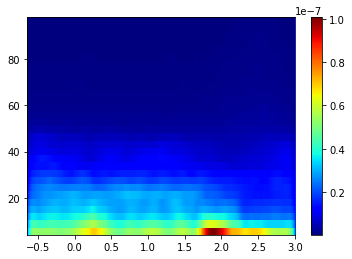

In [73]:
plt.imshow(W_dwt.mean(axis=0), aspect='auto', cmap='jet', origin='lower', 
           extent = [ses.time[0],ses.time[-1],foi[0],foi[-1]])
plt.colorbar()